# This notebook will make a simulation of a mueller beam

In [2]:
import numpy as np, healpy as hp, matplotlib.pyplot as plt
import pygsm,time,copy
import pyuvdata.utils as uvutils
import operator,subprocess,argparse
import os,sys,glob,yaml
import json,itertools,shutil

import colorcet as cc
ccc = cc.m_cyclic_grey_15_85_c0_s25
import matplotlib
import cmocean

from astropy.coordinates import EarthLocation
from mpl_toolkits.axes_grid1 import AxesGrid
from astropy.io import fits
from matplotlib import gridspec
from astropy import wcs
from pyuvdata import UVData
from datetime import datetime
from collections import OrderedDict as odict
from astropy.time import Time
from astropy_healpix import HEALPix
from astropy.coordinates import SkyCoord, Galactic
from astropy import units as u
from astropy import constants as c
from copy import deepcopy
from sympy import *
init_printing(use_unicode=True)
from sympy.physics.quantum import TensorProduct


# Works only in python 2 env
sys.path.insert(0,'/home/gonzalo/Desktop/workstation/cst2ijones/')
from cst2ijones.jones_matrix_field  import InstrumentalJonesMatrixField
from cst2ijones.plotting import PlotMueller
from cst2ijones import spherical_coordinates_basis_transformation as scbt
%matplotlib notebook

In [3]:
# given some frequency n, this function returns the proper file name.
def txtname(n):
    if n not in range(50,251):
        raise ValueError('no data at that frequency.')
    fname = '/home/gonzalo/Desktop/workstation/NF_Simulations/Radiation patterns/E-field pattern - Rigging height 4.9 m/HERA_4.9m_E-pattern_ {}MHz.txt'.format(str(n))
    
    return fname

# Pauli Spin Matricies 
def StokesMatrix(n):
    if n not in [0,1,2,3]: raise Exception('Input must be an integer in [0,1,2,3]')
    
    if n == 0:
        p = np.array([[1.,0],[0.,1.]])
    elif n == 1:
        p = np.array([[1.,0],[0,-1.]])
    elif n == 2:
        p = np.array([[0,1.],[1.,0]])
    elif n == 3:
        p = np.array([[0., -1j],[1j,0]])
    
    return p

# Build Mueller Matrix elements from the pauli spin matrix given some jones matrix, J, at a certain frequency.
def MuellerMatrixElement(J,i,j):
    
    Pi = StokesMatrix(i)
    Pj = StokesMatrix(j)
    
    M_ij = np.einsum('...ab,...bc,...cd,...ad',Pi,J,Pj,J.conj()) / 2. #fancy way of taking the transpose
    
    M_ij = np.real(M_ij)
    
    return M_ij


In [5]:
nu0 = 150
print ("nu0 = {}".format(nu0))
nu_nodes = range(nu0-5,nu0+6)

input_files = [txtname(n) for n in nu_nodes]

# Initialize the Jones matrix with data from simulation
J = InstrumentalJonesMatrixField(input_files, nu_nodes)

# Calculate how to rotate to HERA's latitude
lat = 120.7215 # units of degrees. Remember it runs from [90,-90] so 120deg == -30deg
z0_cza = np.radians(lat) # theta on the sphere is the polar angle
z0 = scbt.r_hat(z0_cza, 0.) # directional vector on sphere (sin(theta)cos(phi),sin(theta)sin(phi),cos(theta))
RotAxis = np.array([0,-1,0])
RotAngle = z0_cza
R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

nu_axis = np.array([nu0]) #np.linspace(nu0-1.,nu0+1., 3, endpoint=True)

nu0 = 150


In [16]:
# BUILD PROPER GRID SIZE
# Determine the proper theta (rad) and phi (rad) values for a Sky Coordinate
# value at a specific HealPix pixel value.
path = '/home/gonzalo/Desktop/workstation/casa_work/'
fitsobject = path+'zen.2458098.52817.HH.calibrated.uvh5_image/zen.2458098.52817.HH.calibrated.uvh5.image.image.fits'

# Load the FITS hdulits
data, header = fits.getdata(fitsobject, header=True)
#header['CRVAL1'] = 0.

In [19]:
header

SIMPLE  =                    T /Standard FITS                                   
BITPIX  =                  -32 /Floating point (32 bit)                         
NAXIS   =                    4                                                  
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    4                                                  
EXTEND  =                    T                                                  
BSCALE  =   1.000000000000E+00 /PHYSICAL = PIXEL*BSCALE + BZERO                 
BZERO   =   0.000000000000E+00                                                  
BMAJ    =   8.713244628906E-01                                                  
BMIN    =   6.809432644314E-01                                                  
BPA     =  -8.221301269531E+

In [17]:
# Parse the WCS keywords in the primary HDU
w = wcs.WCS(header)

# This won't work for rectangular images
npix_sq = header['NAXIS1']

# Convert Equitorial Coordinates to Spherical Coordinates grid
xpix, ypix = np.meshgrid(np.arange(npix_sq),np.arange(npix_sq), indexing='xy')
#np.meshgrid(np.arange(1,npix+1),np.arange(1,npix+1), indexing='xy')
# Should we start from 0 or 1?  aagh
#Right ascension and declination as seen on the inside of the celestial sphere
ra, dec, dummy_freq, dummy_stokes = w.all_pix2world(xpix, ypix,1,1,1) 
c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs') # Coordinates Object

# Convert ra/dec to phi/theta
# don't use ravel because altering the values could change the original data.
theta_grid = np.pi/2. - c_icrs.dec.radian 
theta_flat = np.reshape(theta_grid,-1)

#phi_grid = np.radians(header['CRVAL1']) - c_icrs.ra.radian # azimuthal angle limits [0,2*np.pi]
phi_grid = c_icrs.ra.radian.mean() - c_icrs.ra.radian
phi_flat = np.reshape(phi_grid,-1)

# Calculate rotation around -y (?) to get the beam to point at declination = latitude
z0_cza = np.radians(120.7215)
RotAxis = np.array([0,-1,0])
RotAngle = z0_cza
R_z0 = scbt.rotation_matrix(RotAxis, RotAngle)

theta_hor, phi_hor = scbt.spherical_coordinates_map(R_z0, theta_flat, phi_flat)
phi_hor = 2.*np.pi - phi_hor
ijones_sq = np.reshape(J(nu_axis, theta_hor, phi_hor, R_z0.T),(len(nu_axis),npix_sq, npix_sq, 2, 2))

<IPython.core.display.Javascript object>


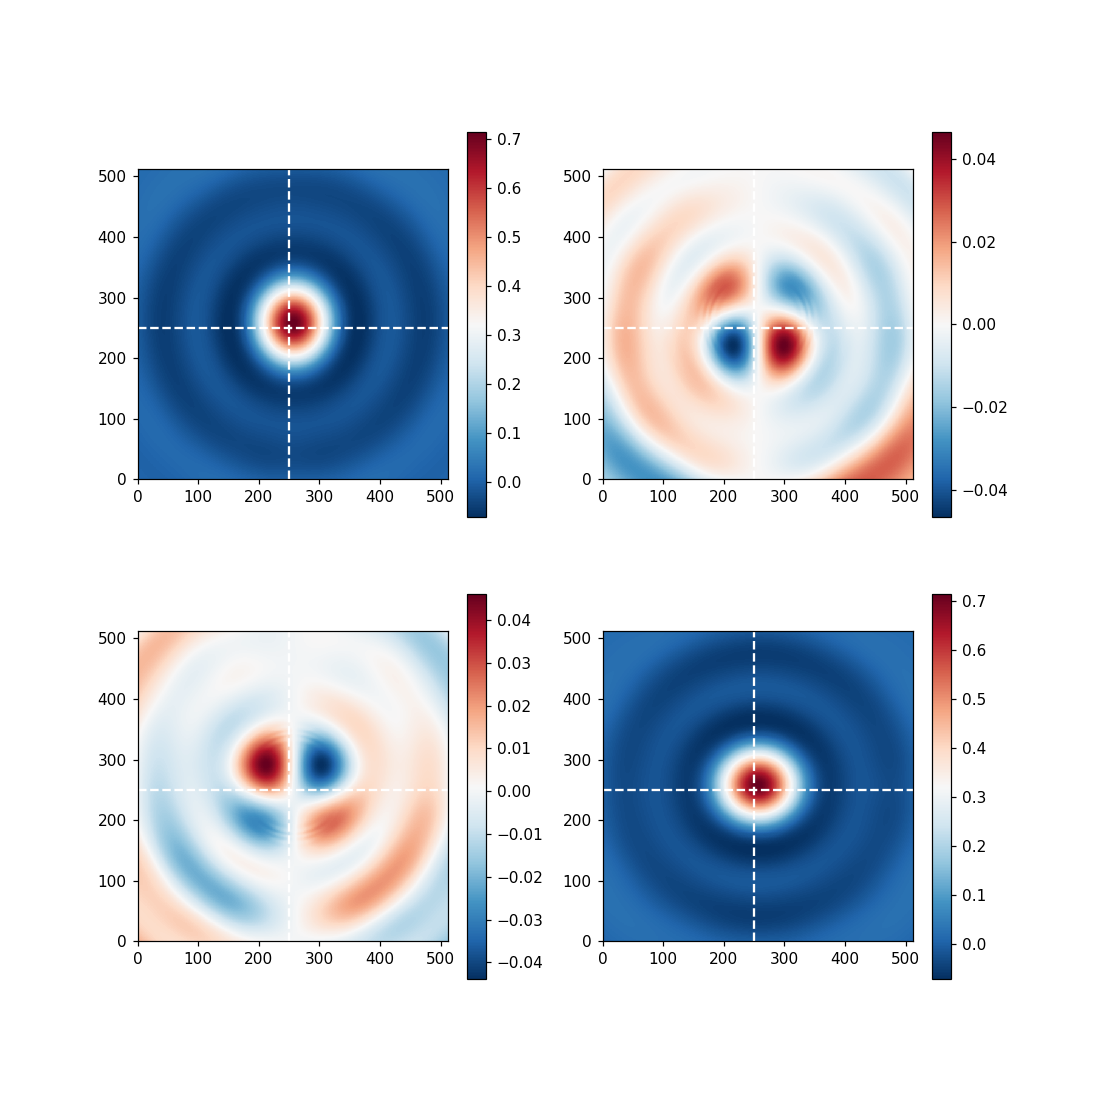

(1, 512, 512, 2, 2)


In [18]:
# Calculcate the theta, phi corresponding to the original coordinate system
def PlotJones(Jones):
    
    plt.figure(figsize=(10,10))
    for i in np.arange(2):
        for j in np.arange(2):
            sp = 2*i + j + 1
            plt.subplot(2,2,sp)
            plt.imshow(np.real(Jones[:,:,i,j]), origin='lower', cmap='RdBu_r')
            plt.axhline(250, color='w', linestyle='--')
            plt.axvline(250, color='w', linestyle='--')
            plt.colorbar()
        
# ijones_sq looks much better

PlotJones(ijones_sq[0])
print(ijones_sq.shape )       

### New Mueller Matrix

Remember, we used astropy to determine the proper coordinates.

**WARNING**: This Mueller matrix does not have the correct axis positions. It is currently *--> [i,j, freq,ra pixel,dec pixel] <--* but it needs to be *--> [ra pixel,dec pixel, freq,i,j] <--*. So you should reshape it and then you can save the data a new fits image file. I did it for you but it's commented out.

In [29]:
# Generate Simulation of the Mueller Matrix
i_index,j_index = 4,4
nchan = len(nu_axis)
#MuellerMatrixij_sq = np.zeros((i_index,j_index,nchan,npix,npix),dtype=np.float64) # [i,j, freq,ra pixel,dec pixel]
new_mueller = np.zeros((npix_sq,npix_sq,nchan,4,4),dtype=np.float64) # [ra pixel,dec pixel, freq,i,j]

for f in range(ijones_sq.shape[0]):
    for i in range(i_index):
        for j in range(j_index):
            #MuellerMatrixij_sq[i,j,f,:,:] = MuellerMatrixElement(ijones_sq[f],i,j)
            new_mueller[:,:,f,i,j] = MuellerMatrixElement(ijones_sq[f],i,j)

In [30]:
new_mueller.shape

<IPython.core.display.Javascript object>


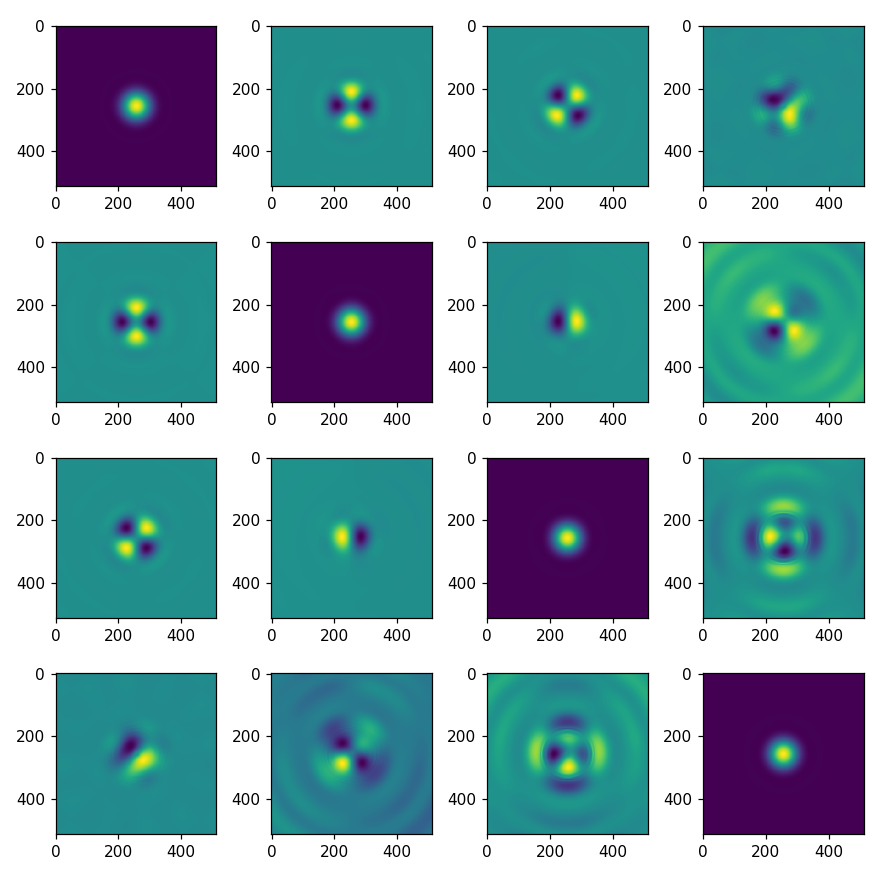

In [31]:
%matplotlib notebook
# Make Plot
iarr = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
jarr = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

f,axarr = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,8))
gs = gridspec.GridSpec(4,4)#, wspace=0.01, hspace=0.1)

for i in range(len(iarr)):
    
    ax=plt.subplot(gs[iarr[i],jarr[i]])
    #ax.imshow(MuellerMatrixij_sq[iarr[i],jarr[i],0,:,:])
    #ax.imshow(new_mueller[iarr[i],jarr[i],0,:,:])
    ax.imshow(new_mueller[:,:,0,iarr[i],jarr[i]])


plt.tight_layout()

plt.show()
plt.savefig('muellerbeam_axis_i_j_freq_ra_dec')
#plt.savefig('muellerbeam_axis_ra_dec_freq_i_j')

In [35]:
#PrimaryHDU
#hdu = fits.PrimaryHDU(data=MuellerMatrixij_sq,header=header)
hdu_mueller = fits.PrimaryHDU(data=new_mueller.T)#,header=header)

In [36]:
hdu_mueller.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    5 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    4                                                  
NAXIS5  =                    4                                                  
EXTEND  =                    T                                                  

In [9]:
k in header.keys():
    if k == '':
        continue
    if k == 'HISTORY':
        continue
    else:
        new_hdu.header.append((k,header[k]))

# write new GSM model out to a FITS file
mb_filename='/home/gonzalo/Desktop/workstation/MuellerMatrixBeam{}MHz.fits'.format(nu0)
hdu.writeto(mb_filename,overwrite=True)
mb = fits.open(mb_filename)
mb[0].header['CTYPE4']='Mueller Components' # Change the name
mb.writeto(mb_filename,overwrite=True)

In [37]:
w

WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 111.3405377933  -30.685519565  151269536.7898  1.0  
CRPIX : 257.0  257.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.1388888888889  0.1388888888889  73339854.82962  1.0  
NAXIS : 512  512  1  4

In [39]:
w.to_header()

WCSAXES =                    4 / Number of coordinate axes                      
CRPIX1  =                257.0 / Pixel coordinate of reference point            
CRPIX2  =                257.0 / Pixel coordinate of reference point            
CRPIX3  =                  1.0 / Pixel coordinate of reference point            
CRPIX4  =                  1.0 / Pixel coordinate of reference point            
CDELT1  =     -0.1388888888889 / [deg] Coordinate increment at reference point  
CDELT2  =      0.1388888888889 / [deg] Coordinate increment at reference point  
CDELT3  =       73339854.82962 / [Hz] Coordinate increment at reference point   
CDELT4  =                  1.0 / Coordinate increment at reference point        
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CUNIT3  = 'Hz'                 / Units of coordinate increment and value        
CTYPE1  = 'RA---SIN'        

In [40]:
hdu_mueller.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    5 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    4                                                  
NAXIS5  =                    4                                                  
EXTEND  =                    T                                                  

In [41]:
wcs_header = w.to_header()
for k in wcs_header.keys():
    hdu_mueller.header[k] = wcs_header[k]

In [42]:
hdu_mueller.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    5 / number of array dimensions                     
NAXIS1  =                  512                                                  
NAXIS2  =                  512                                                  
NAXIS3  =                    1                                                  
NAXIS4  =                    4                                                  
NAXIS5  =                    4                                                  
EXTEND  =                    T                                                  
WCSAXES =                    4                                                  
CRPIX1  =                257.0                                                  
CRPIX2  =                257.0                                                  
CRPIX3  =                  1